# DNA Content analysis

A cell's DNA content is quantized by the DAPI stain.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load common_.py
from common import *

In [3]:
from ehv import core, load as e_load, correlation, viral, fluorescence_intensity
from joblib import dump, load
from pathlib import Path
import matplotlib
import re
import umap

In [4]:
samples = None
df = e_load.load_raw_ideas_dir(
    Path("/data/weizmann/EhV/high_time_res"), 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/representations/ideas_features/"), 
    "ALL", 
    Path("/data/weizmann/EhV/weizmann-ehv-metadata/cell_populations/manual_gating/"),
    samples, "Low/*.cif")
df = e_load.remove_unwanted_features(df)
df = e_load.tag_columns(df)
df = e_load.clean_column_names(df)

df = df[df["meta_label_coi"]]

reg = r"^meta_label_(.+)$"
label_vec = numpy.full((df.shape[0]), fill_value="unknown", dtype=object)
for col in df.filter(regex="(?i)meta_label_.*psba.*"):
    label_vec[df[col].values] = re.match(reg, col).groups(1)
    
df["meta_label"] = label_vec

df = df.reset_index(drop=True)

In [5]:
projection = load("/data/weizmann/EhV/weizmann-ehv-metadata/representations/umap/Low/c8ba196c-0b22-4489-9f9c-1242f68dd7a5.dat")

df["dim_1"] = projection[:, 0]
df["dim_2"] = projection[:, 1]

In [6]:
df = df[df["meta_label"]!="unknown"]

In [7]:
# df = pandas.concat([df, viral.logicle_transform(df)], axis=1)
df = fluorescence_intensity.apply_logicle(df)

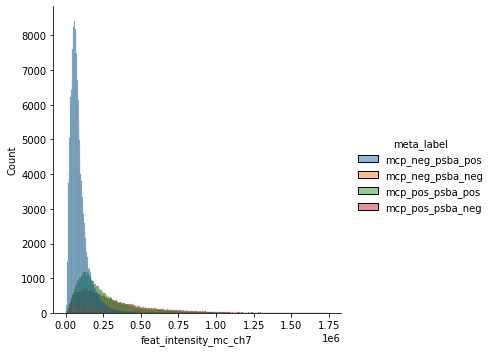

In [8]:
seaborn.displot(data=df, x="feat_intensity_mc_ch7", hue="meta_label")

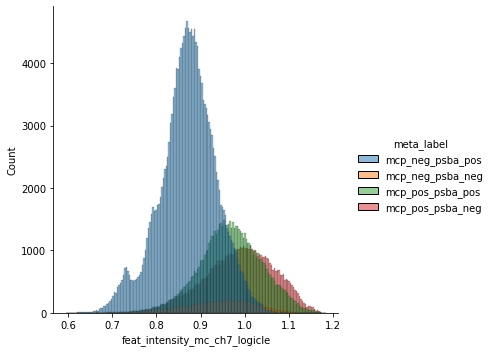

In [9]:
seaborn.displot(data=df, x="feat_intensity_mc_ch7_logicle", hue="meta_label")

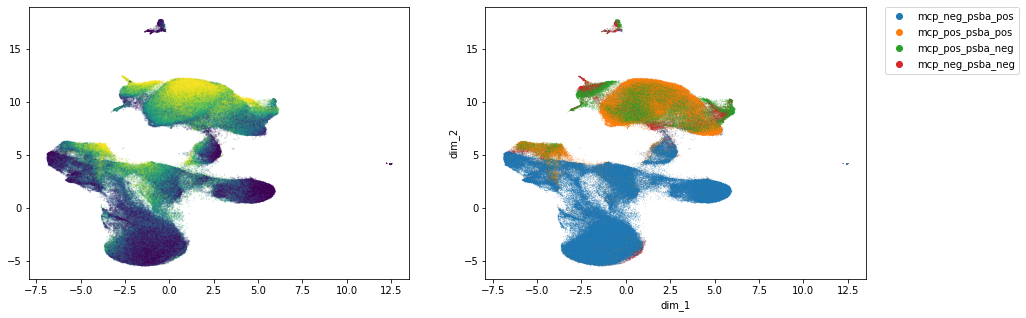

In [10]:
fig, axes = plt.subplots(1,2, figsize=(15,5))
feat = "feat_intensity_mc_ch7_logicle"
norm = matplotlib.colors.Normalize(vmin=df[feat].quantile(0.1), vmax=df[feat].quantile(0.9))
axes[0].scatter(df["dim_1"], df["dim_2"], c=df[feat], s=0.01, cmap="viridis", norm=norm)
seaborn.scatterplot(data=df, x="dim_1", y="dim_2", hue="meta_label", s=0.5, linewidth=0, alpha=0.5, legend="full", hue_order=["mcp_neg_psba_pos", "mcp_pos_psba_pos", "mcp_pos_psba_neg", "mcp_neg_psba_neg"], ax=axes[1])
axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Identifying G1 and G2 phase in early timepoints

In [8]:
early_tp_df = df[df["meta_timepoint"] < 8].copy()

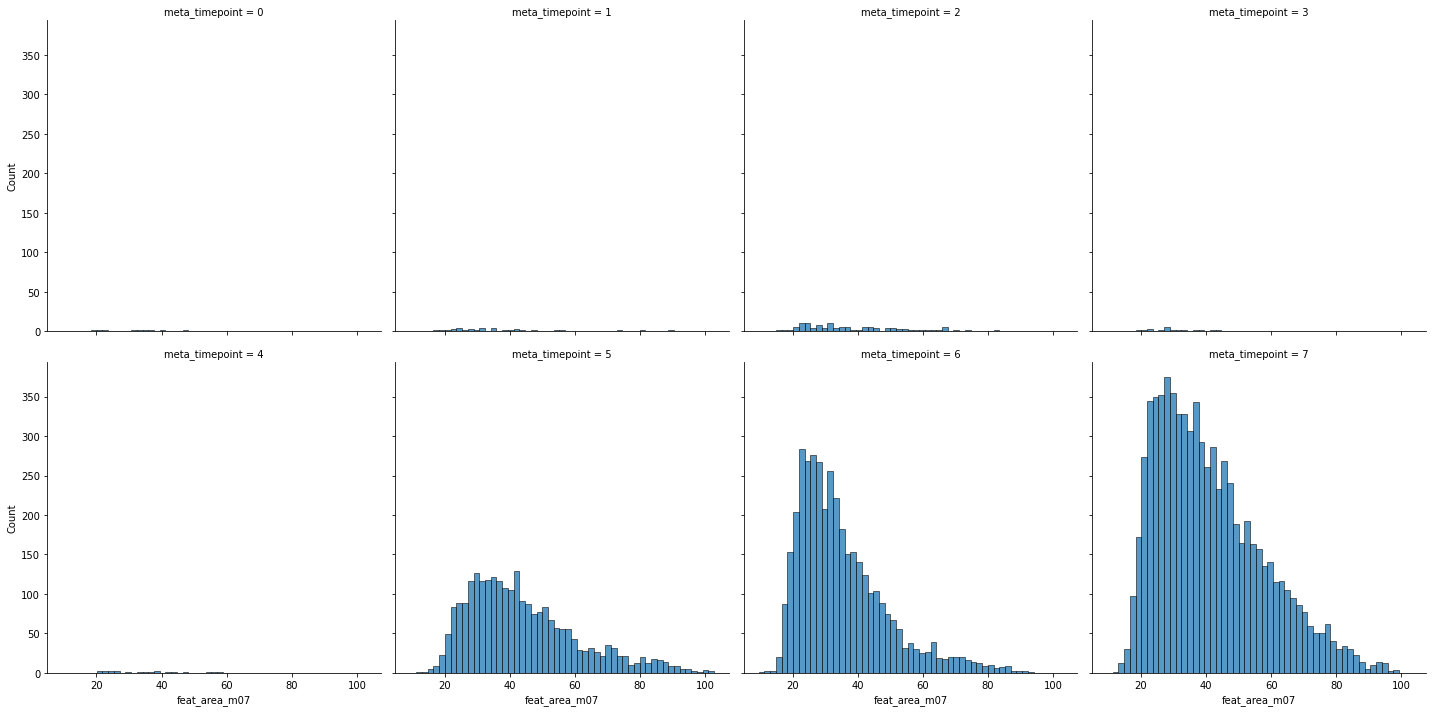

In [14]:
seaborn.displot(data=early_tp_df[early_tp_df["meta_label_mcp_pos_psba_pos"]], x="feat_area_m07", col="meta_timepoint", col_wrap=4)

In [15]:
early_tp_df["meta_phase"] = ""
early_tp_df.loc[early_tp_df["feat_area_m07"] < 40, "meta_phase"] = "g1"
early_tp_df.loc[early_tp_df["feat_area_m07"] > 60, "meta_phase"] = "g2"

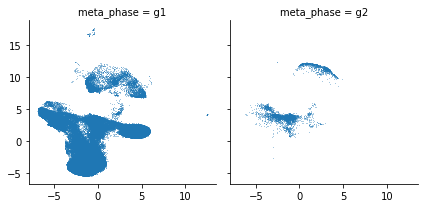

In [16]:
grid = seaborn.FacetGrid(data=early_tp_df[early_tp_df["meta_phase"] != ""], col="meta_phase")
grid.map_dataframe(seaborn.scatterplot, x="dim_1", y="dim_2", s=1, alpha=0.5, linewidth=0)

<AxesSubplot:xlabel='meta_phase', ylabel='count'>

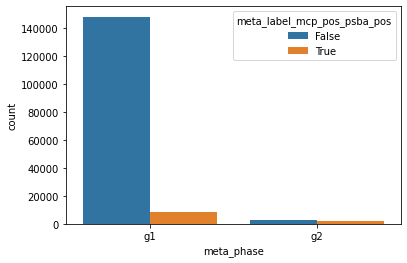

In [17]:
seaborn.countplot(data=early_tp_df[early_tp_df["meta_phase"] != ""], x="meta_phase", hue="meta_label_mcp_pos_psba_pos")

In [18]:
agg_df = early_tp_df[early_tp_df["meta_phase"] != ""].groupby(["meta_phase", "meta_label_mcp_pos_psba_pos"]).size()
print("Percentage infected cells of cells in G1: {:.2f}%".format((agg_df["g1"][True]/sum(agg_df["g1"]))*100))
print("Percentage infected cells of cells in G2: {:.2f}%".format((agg_df["g2"][True]/sum(agg_df["g2"]))*100))

Percentage infected cells of cells in G1: 5.22%
Percentage infected cells of cells in G2: 38.07%


<AxesSubplot:xlabel='meta_phase', ylabel='count'>

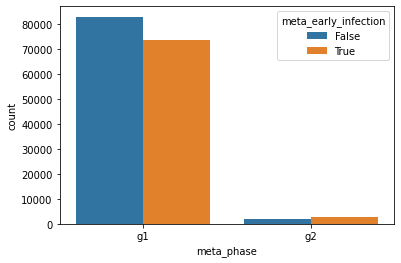

In [19]:
early_infection_selector = (
    (early_tp_df["feat_intensity_mc_ch04"] < early_tp_df["feat_intensity_mc_ch04"].median()) &
    (early_tp_df["feat_intensity_mc_ch11_logicle"] > 0)
)
early_tp_df["meta_early_infection"] = False
early_tp_df.loc[early_infection_selector, "meta_early_infection"] = True
seaborn.countplot(data=early_tp_df[early_tp_df["meta_phase"] != ""], x="meta_phase", hue="meta_early_infection")

In [20]:
agg_df = early_tp_df[early_tp_df["meta_phase"] != ""].groupby(["meta_phase", "meta_early_infection"]).size()
print("Percentage infected cells of cells in G1: {:.2f}%".format((agg_df["g1"][True]/sum(agg_df["g1"]))*100))
print("Percentage infected cells of cells in G2: {:.2f}%".format((agg_df["g2"][True]/sum(agg_df["g2"]))*100))

Percentage infected cells of cells in G1: 47.02%
Percentage infected cells of cells in G2: 60.73%


# Fraction of cells in phase in function of MCP intensity

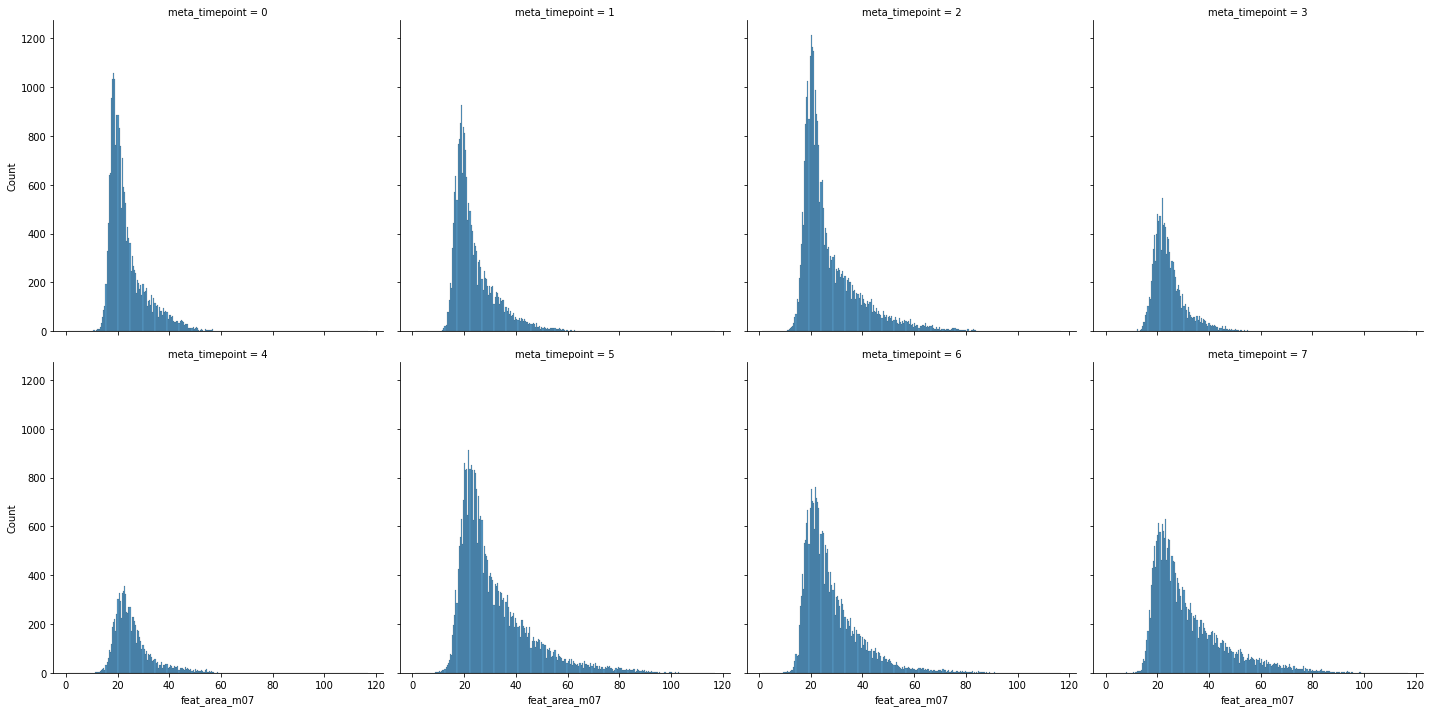

In [25]:
seaborn.displot(data=early_tp_df[early_tp_df["feat_intensity_mc_ch11_logicle"] > 0], x="feat_area_m07", col="meta_timepoint", col_wrap=4)

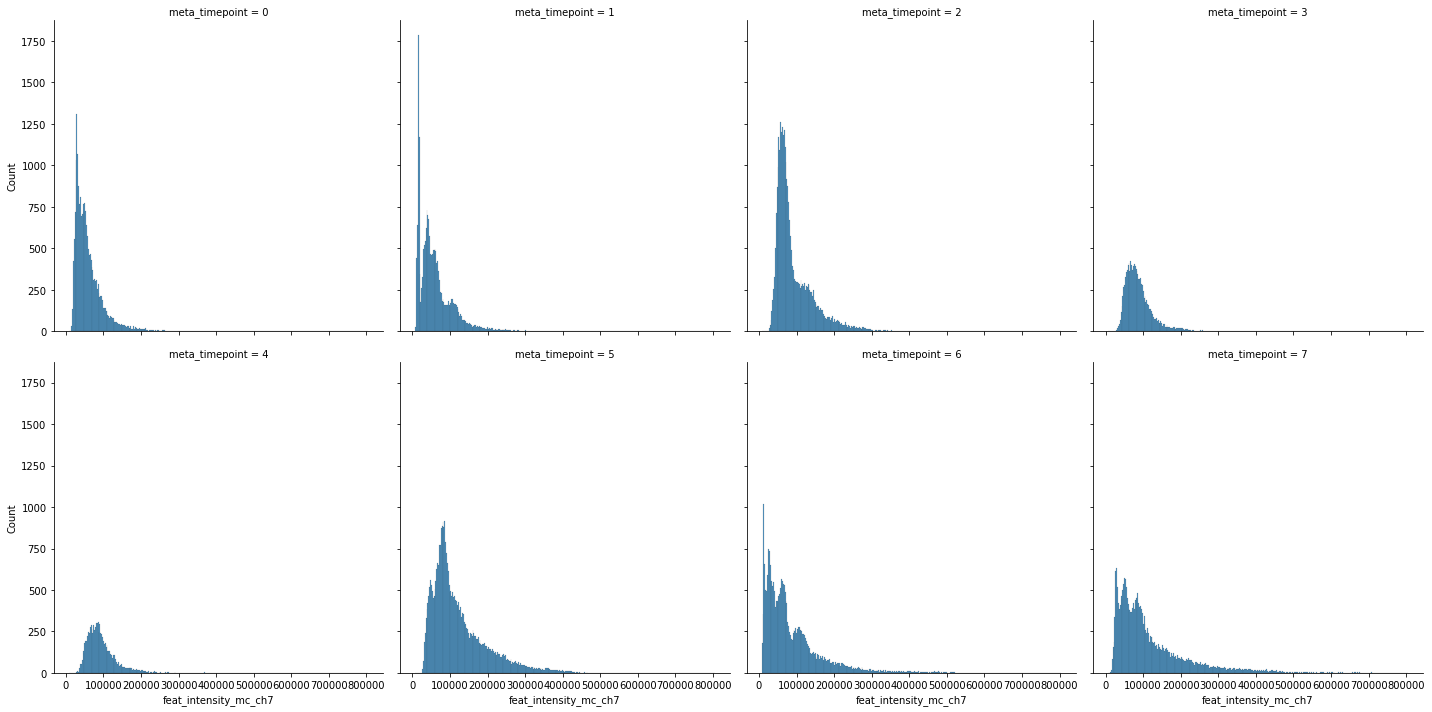

In [24]:
seaborn.displot(data=early_tp_df[early_tp_df["feat_intensity_mc_ch11_logicle"] > 0], x="feat_intensity_mc_ch7", col="meta_timepoint", col_wrap=4)

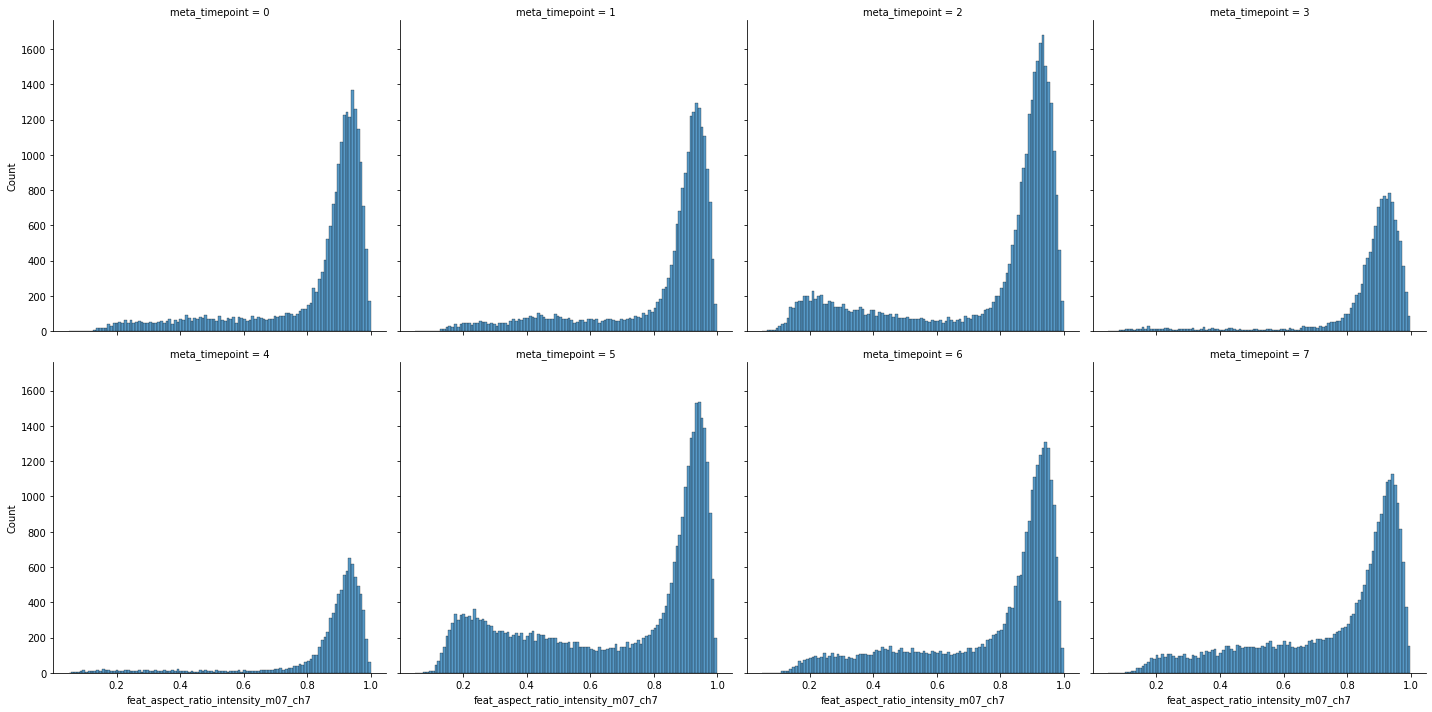

In [9]:
seaborn.displot(data=early_tp_df[early_tp_df["feat_intensity_mc_ch11_logicle"] > 0], x="feat_aspect_ratio_intensity_m07_ch7", col="meta_timepoint", col_wrap=4)
plt.savefig("figs/feat_aspect_ratio_intensity_m07_ch7.png")

In [10]:
early_tp_df["meta_mcp_bin"] = pandas.cut(early_tp_df["feat_intensity_mc_ch04"], bins=100, labels=[i for i in range(100)])

In [11]:
early_tp_df["meta_phase"] = "other"
early_tp_df.loc[early_tp_df["feat_aspect_ratio_intensity_m07_ch7"] < 0.3, "meta_phase"] = "g2"
early_tp_df.loc[early_tp_df["feat_aspect_ratio_intensity_m07_ch7"] > 0.8, "meta_phase"] = "g1"

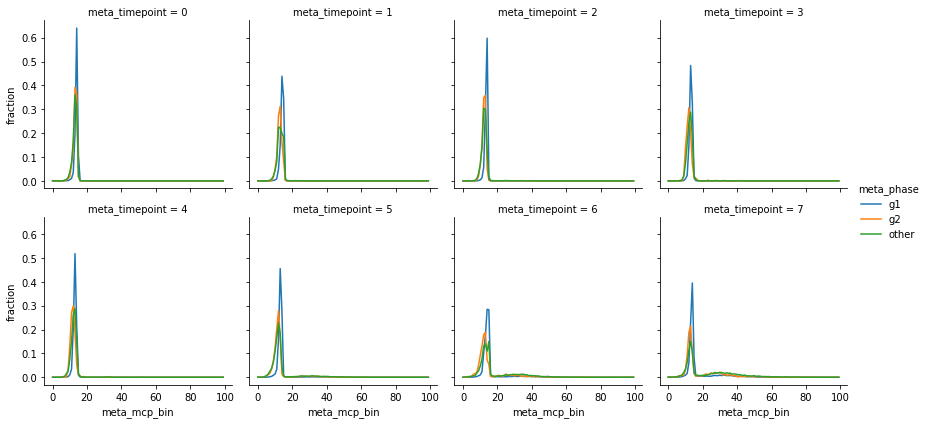

In [41]:
tmp_df = (
    early_tp_df.groupby(["meta_timepoint", "meta_mcp_bin", "meta_phase"]).size()/
    early_tp_df.groupby(["meta_timepoint", "meta_phase"]).size()
)
tmp_df.name = "fraction"
tmp_df = tmp_df.to_frame().reset_index()

grid = seaborn.FacetGrid(data=tmp_df, hue="meta_phase", col="meta_timepoint", col_wrap=4)
grid.map_dataframe(plt.plot, "meta_mcp_bin", "fraction")
grid.add_legend()

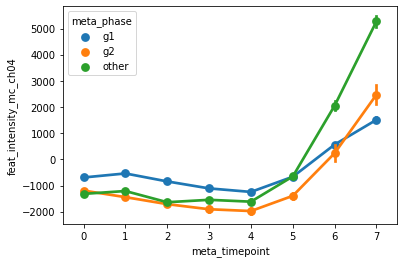

In [45]:
seaborn.pointplot(data=early_tp_df, x="meta_timepoint", y="feat_intensity_mc_ch04", hue="meta_phase")
plt.savefig("figs/feat_intensity_mc_ch04_meta_phase.png")

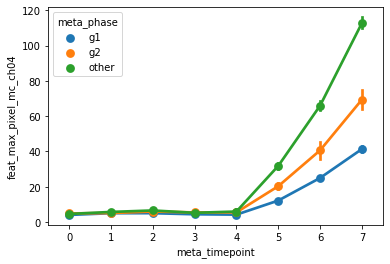

In [12]:
seaborn.pointplot(data=early_tp_df, x="meta_timepoint", y="feat_max_pixel_mc_ch04", hue="meta_phase")
plt.savefig("figs/feat_max_pixel_mc_ch04_meta_phase.png")

<AxesSubplot:xlabel='meta_timepoint', ylabel='count'>

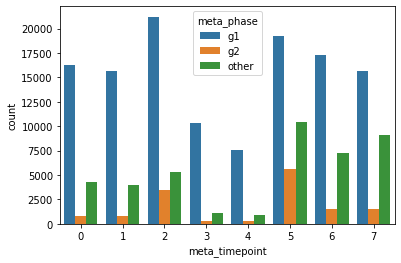

In [13]:
seaborn.countplot(data=early_tp_df[early_tp_df["meta_phase"] != ""], x="meta_timepoint", hue="meta_phase")